# CUSUM trading techniques for Cryptos

## 1. Lam and Yam (1997)
CUSUM based filter trading strategy.

### Load data
Watch list: top nine cryptocurrencies (ranked by market capitalization) plus Dogecoin, as of November 2021
+ Bitcoin, Ethereum, Solana, Ripple, Binance Coin, Tether, Cardano, Polkadot, Terra, Dogecoin

In [3]:
# install pmdarima library
# !pip install pmdarima

In [4]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot


# just set the seed for the random number generator
np.random.seed(107)

plt.rcParams['figure.figsize'] = (16, 9)
warnings.filterwarnings('ignore')

In [5]:
cryptos = pd.read_csv("../data/crypto_1y.csv", parse_dates=True, index_col="time")
cryptos.head()

,BTC,ETH,SOL,XRP,BNB,USDT,ADA,DOT,LUNA,DOGE
time,,,,,,,,,,
2020-11-01 01:00:00,13770.78,389.16,1.556,0.2403,28.59,1.002,0.09378,4.194,0.3030,0.002549
2020-11-01 02:00:00,13721.73,387.91,1.553,0.2393,28.39,1.002,0.09374,4.193,0.3011,0.002570
2020-11-01 03:00:00,13700.10,386.75,1.534,0.2392,28.40,1.002,0.09355,4.177,0.3013,0.002574
2020-11-01 04:00:00,13683.91,386.57,1.529,0.2391,28.23,1.002,0.09338,4.157,0.3002,0.002567
2020-11-01 05:00:00,13705.51,386.08,1.531,0.2391,28.27,1.002,0.09315,4.143,0.3006,0.002611


### Generalized CUSUM filter rule

For simplicity, we do not allow short thus we always start by detecting a buy signal. Then we try to detect sell signal after a buy signal.

To do later:
1. Find optimal k, h value
2. Optimize plots
3. Backtest

In [88]:
# should test for an optimal k, h
k = 0.005
h = 10*k

def trainTestSplit(df):
    df = df.loc[df.index>='2021-05-01', :]
    return df.loc[df.index<'2021-09-01', :], df.loc[df.index>='2021-09-01', :]


def calculateReturn(df, coin: str):
    df.loc[:, "price"] = df.loc[:, coin]
    df.loc[:, "logPrice"] = np.log(df.loc[:, "price"])
    df.loc[:, "return"] = df.loc[:, "logPrice"] - df.loc[:, "logPrice"].shift(1)
    
    df.loc[df.index[0], "return"] = 0
    df.loc[df.index[0], 'signal'] = 0
    cols = ['price', 'logPrice', 'return', 'signal']
    return df.loc[:, cols]


def detectSellSignal(df, start, feature, method):
    df.loc[df.index[start], 'cMinus'] = 0
    for i in range(start+1, len(df)):
        if method == "montgomery":
            cMinus = np.min([0, -df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], feature]+k])
        else:
            cMinus = np.min([0, df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], feature]-k])
        df.loc[df.index[i], 'cMinus'] = cMinus
        
        if cMinus <= -h:
            # sell signal appears
            df.loc[df.index[i], 'signal'] = -1
            df.loc[df.index[i], 'share'] = 0
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'share'] *  df.loc[df.index[i], 'price']
            return detectBuySignal(df, i, feature=feature, method=method)
        else:
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i], 'share'] * df.loc[df.index[i], 'price']
            
    return df


def detectBuySignal(df, start, feature, method):
    transactionFee = 0.5 / 100
    df.loc[df.index[start], "cPlus"] = 0
    for i in range(start+1, len(df)):
        cPlus = np.max([0, df.loc[df.index[i-1], 'cPlus'] + df.loc[df.index[i], feature]-k])
        df.loc[df.index[i], 'cPlus'] = cPlus
        
        if cPlus >= h:
            # buy signal appears
            df.loc[df.index[i], 'signal'] = 1
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity'] * (1-transactionFee)
            df.loc[df.index[i], 'share'] = df.loc[df.index[i], 'equity'] / df.loc[df.index[i], 'price']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity']
            return detectSellSignal(df, i, feature=feature, method=method)
        else:
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity']
            
    return df


def createTradeSignal(df, feature='return', method="montgomery"):
    df.loc[df.index[0], 'equity'] = 100
    df.loc[df.index[0], 'share'] = 0
    return detectBuySignal(df, start=0, feature=feature, method=method)

In [89]:
traindf, testdf = trainTestSplit(cryptos)

coin = "BTC"

df = (traindf
      .pipe(calculateReturn, coin)
      .pipe(createTradeSignal)) # , method="46"

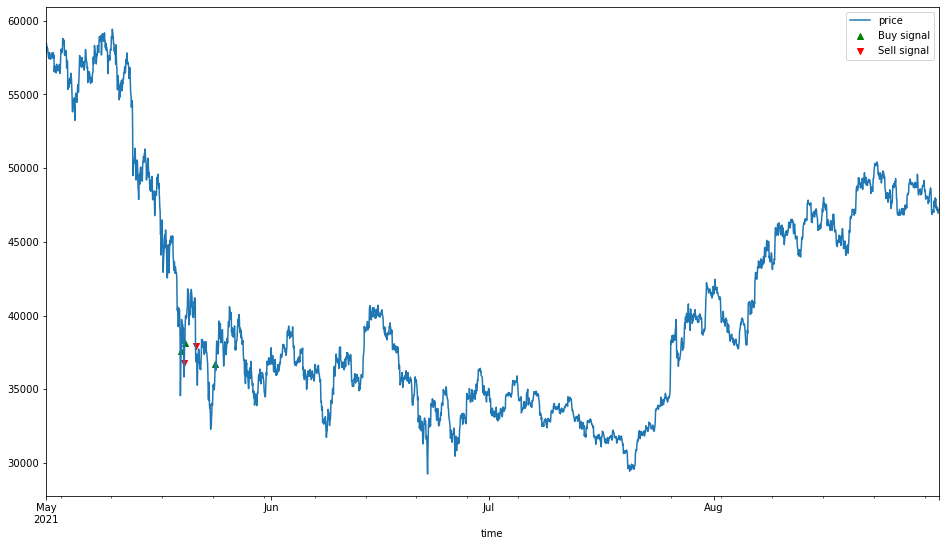

In [87]:
def plotPriceWithSignal(df):
    # optimze looking later
    df.loc[:, 'price'].plot()
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.legend(loc='best')
    plt.show()
    
plotPriceWithSignal(df.head(10000))

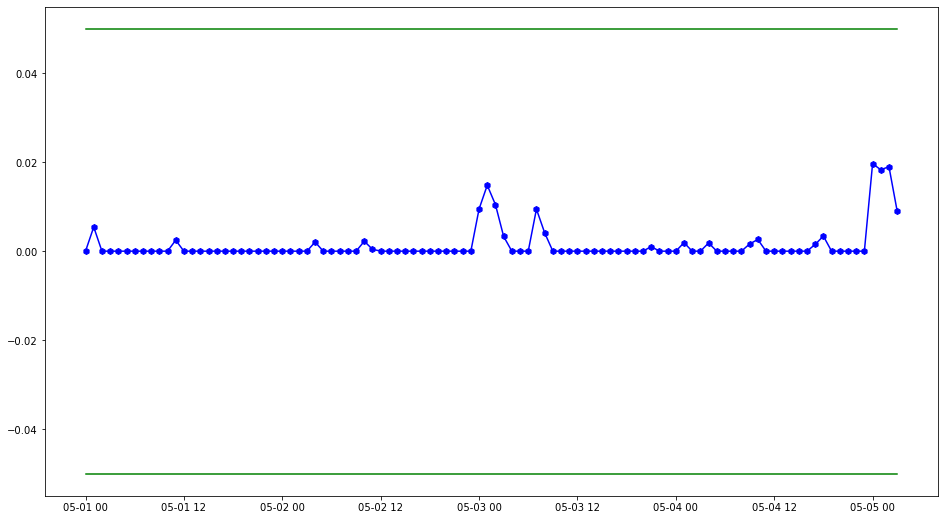

In [75]:
def plotCUSUM(df):
    plt.plot(df.index,df['cPlus'], color='b', marker='h', markersize=6)
    plt.plot(df.index,df['cMinus'], color='r', marker='h', markersize=6)
    plt.plot(df.index,np.array([h]*len(df.index)),color='g')
    plt.plot(df.index,np.array([-h]*len(df.index)),color='g')
    plt.show()
    

plotCUSUM(df.head(100))

In [90]:
### to delete
# calculate profit
buyPrice = df.loc[df['signal']==1, 'price']
sellPrice = df.loc[df['signal']==-1, 'price']
buyPriceEven = buyPrice[:len(sellPrice)]
np.sum((sellPrice.values-buyPriceEven.values)/buyPriceEven.values)

-0.027773356897836936

<AxesSubplot:xlabel='time'>

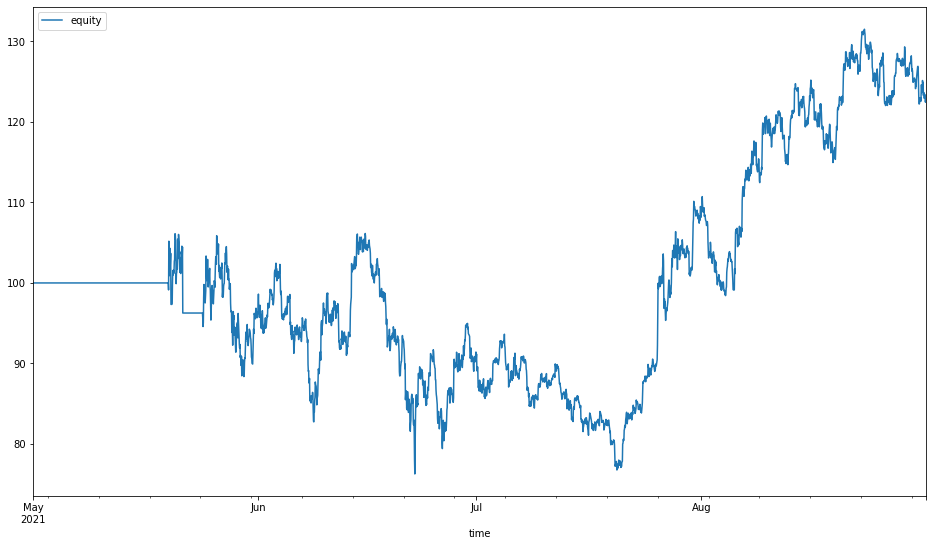

In [93]:
df.loc[:,['equity']].plot()

## 2. Yi *et al* (2006)

Take transaction fee of each buying and selling into consideration for each trading cycle.

In [11]:
def calculateTransactionFee(df):
    # get trading prices
    buyPrice = df.loc[df['signal']==1, 'price']
    sellPrice = df.loc[df['signal']==-1, 'price']
    buyPriceEven = buyPrice[:len(sellPrice)]

    profitOfEachCycle = []
    for buy, sell in zip(buyPriceEven, sellPrice):
        profitOfEachCycle.append( sell/buy )

    totalProfit = np.prod(profitOfEachCycle)

    buyTime = df.loc[df['signal']==1, :].index
    sellTime = df.loc[df['signal']==-1, :].index
    buyTimeEven = buyTime[:len(sellTime)]

    cycleLength = [] 
    for buy, sell in zip(buyTimeEven, sellTime):
        cycleLength.append(sell - buy)

    totalCycleLength = np.sum(cycleLength) / timedelta(hours=1) # hours
    # average porfit without transaction fee
    averageHourlyProfit = (totalProfit-1) / totalCycleLength

    feeRate = 0.005
    totalProfitWithFee = totalProfit * (1-feeRate)**(2*len(buyTimeEven))
    # average porfit with transaction fee
    averageHourlyProfitWithFee = (totalProfitWithFee-1) / totalCycleLength

    return (totalProfit, totalProfitWithFee,
            averageHourlyProfit, averageHourlyProfitWithFee)

In [12]:
profitMetrics = calculateTransactionFee(df)
profitMetrics

(1.1203138362981209,
 0.0481098948855701,
 6.740270941071197e-05,
 -0.0005332717675711092)

## 3. Žmuk (2016)

Deal with autocorrelation in our data.

### ARIMA(p,d,q)

In [13]:
def applyARIMA(df, coin):
    df.loc[:, "price"] = df.loc[:, coin]
    autoARIMA = auto_arima(df['price'],
                       start_p=0, max_p=5,
                       d=0, max_d=2,
                       start_q=0, max_q=5)
    print("Auto ARIMA parameters: ", autoARIMA.order)
    model = ARIMA(df['price'], order=autoARIMA.order)
    model_fit = model.fit()
    df.loc[:, 'residual'] = model_fit.resid
    return df


def plotBeforeAndAfterARIMA(df):
    autocorrelation_plot(df['price'], label="Price")
    autocorrelation_plot(df['residual'], label="ARIMA")
    plt.legend(loc='best')
    plt.show()

to do:

1. residual-based cusum
2. grid search
2. backtest
3. risk-adjusted

## 4. Chen and Huang (2012)

### Residual based CUSUM chart

In [14]:
def calculateResidualFeature(df):
    std = np.std(df.loc[:, 'residual'])
    df.loc[:, 'residualFeature'] = df.loc[:, 'residual'] / std
    return df

Auto ARIMA parameters:  (1, 0, 2)
Buy at  2021-05-01 01:00:00
Sell at  2021-05-01 02:00:00
Buy at  2021-05-01 03:00:00
Sell at  2021-05-01 04:00:00
Buy at  2021-05-01 05:00:00
Sell at  2021-05-01 06:00:00
Buy at  2021-05-01 09:00:00
Sell at  2021-05-01 10:00:00
Buy at  2021-05-01 11:00:00
Sell at  2021-05-01 12:00:00
Buy at  2021-05-01 16:00:00
Sell at  2021-05-01 20:00:00
Buy at  2021-05-01 22:00:00
Sell at  2021-05-02 00:00:00
Buy at  2021-05-02 02:00:00
Sell at  2021-05-02 03:00:00
Buy at  2021-05-02 04:00:00
Sell at  2021-05-02 05:00:00
Buy at  2021-05-02 10:00:00
Sell at  2021-05-02 12:00:00
Buy at  2021-05-02 14:00:00
Sell at  2021-05-02 15:00:00
Buy at  2021-05-02 16:00:00
Sell at  2021-05-02 21:00:00
Buy at  2021-05-02 23:00:00
Sell at  2021-05-03 03:00:00
Buy at  2021-05-03 05:00:00
Sell at  2021-05-03 08:00:00
Buy at  2021-05-03 10:00:00
Sell at  2021-05-03 12:00:00
Buy at  2021-05-03 14:00:00
Sell at  2021-05-03 15:00:00
Buy at  2021-05-03 16:00:00
Sell at  2021-05-03 18:00:

Buy at  2021-06-10 21:00:00
Sell at  2021-06-10 23:00:00
Buy at  2021-06-11 02:00:00
Sell at  2021-06-11 05:00:00
Buy at  2021-06-11 07:00:00
Sell at  2021-06-11 08:00:00
Buy at  2021-06-11 09:00:00
Sell at  2021-06-11 11:00:00
Buy at  2021-06-11 13:00:00
Sell at  2021-06-11 14:00:00
Buy at  2021-06-11 17:00:00
Sell at  2021-06-11 20:00:00
Buy at  2021-06-11 22:00:00
Sell at  2021-06-11 23:00:00
Buy at  2021-06-12 03:00:00
Sell at  2021-06-12 04:00:00
Buy at  2021-06-12 06:00:00
Sell at  2021-06-12 07:00:00
Buy at  2021-06-12 09:00:00
Sell at  2021-06-12 11:00:00
Buy at  2021-06-12 12:00:00
Sell at  2021-06-12 13:00:00
Buy at  2021-06-12 16:00:00
Sell at  2021-06-12 19:00:00
Buy at  2021-06-12 20:00:00
Sell at  2021-06-12 21:00:00
Buy at  2021-06-13 00:00:00
Sell at  2021-06-13 02:00:00
Buy at  2021-06-13 04:00:00
Sell at  2021-06-13 05:00:00
Buy at  2021-06-13 06:00:00
Sell at  2021-06-13 07:00:00
Buy at  2021-06-13 08:00:00
Sell at  2021-06-13 11:00:00
Buy at  2021-06-13 15:00:00
Sel

Buy at  2021-07-19 14:00:00
Sell at  2021-07-19 15:00:00
Buy at  2021-07-19 16:00:00
Sell at  2021-07-19 18:00:00
Buy at  2021-07-19 19:00:00
Sell at  2021-07-19 21:00:00
Buy at  2021-07-19 22:00:00
Sell at  2021-07-19 23:00:00
Buy at  2021-07-20 04:00:00
Sell at  2021-07-20 06:00:00
Buy at  2021-07-20 07:00:00
Sell at  2021-07-20 08:00:00
Buy at  2021-07-20 10:00:00
Sell at  2021-07-20 11:00:00
Buy at  2021-07-20 12:00:00
Sell at  2021-07-20 13:00:00
Buy at  2021-07-20 14:00:00
Sell at  2021-07-20 16:00:00
Buy at  2021-07-20 18:00:00
Sell at  2021-07-20 19:00:00
Buy at  2021-07-20 20:00:00
Sell at  2021-07-20 21:00:00
Buy at  2021-07-20 23:00:00
Sell at  2021-07-21 00:00:00
Buy at  2021-07-21 01:00:00
Sell at  2021-07-21 07:00:00
Buy at  2021-07-21 08:00:00
Sell at  2021-07-21 12:00:00
Buy at  2021-07-21 13:00:00
Sell at  2021-07-21 18:00:00
Buy at  2021-07-21 20:00:00
Sell at  2021-07-21 21:00:00
Buy at  2021-07-21 22:00:00
Sell at  2021-07-22 00:00:00
Buy at  2021-07-22 03:00:00
Sel

Buy at  2021-08-27 04:00:00
Sell at  2021-08-27 08:00:00
Buy at  2021-08-27 09:00:00
Sell at  2021-08-27 12:00:00
Buy at  2021-08-27 14:00:00
Sell at  2021-08-27 17:00:00
Buy at  2021-08-27 18:00:00
Sell at  2021-08-27 19:00:00
Buy at  2021-08-27 20:00:00
Sell at  2021-08-28 01:00:00
Buy at  2021-08-28 04:00:00
Sell at  2021-08-28 05:00:00
Buy at  2021-08-28 06:00:00
Sell at  2021-08-28 07:00:00
Buy at  2021-08-28 09:00:00
Sell at  2021-08-28 10:00:00
Buy at  2021-08-28 12:00:00
Sell at  2021-08-28 13:00:00
Buy at  2021-08-28 15:00:00
Sell at  2021-08-28 18:00:00
Buy at  2021-08-28 20:00:00
Sell at  2021-08-28 22:00:00
Buy at  2021-08-28 23:00:00
Sell at  2021-08-29 01:00:00
Buy at  2021-08-29 05:00:00
Sell at  2021-08-29 10:00:00
Buy at  2021-08-29 12:00:00
Sell at  2021-08-29 13:00:00
Buy at  2021-08-29 15:00:00
Sell at  2021-08-29 18:00:00
Buy at  2021-08-29 19:00:00
Sell at  2021-08-29 23:00:00
Buy at  2021-08-30 01:00:00
Sell at  2021-08-30 02:00:00
Buy at  2021-08-30 05:00:00
Sel

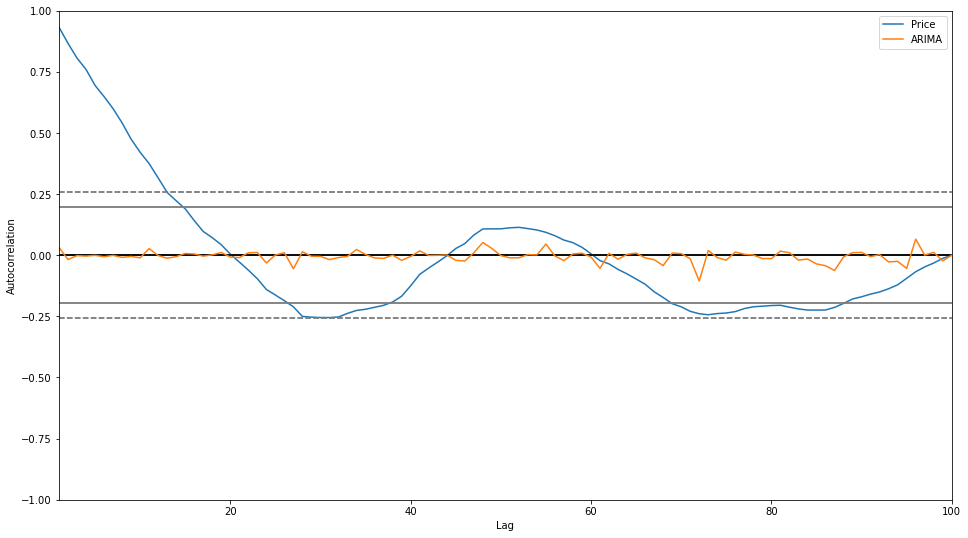

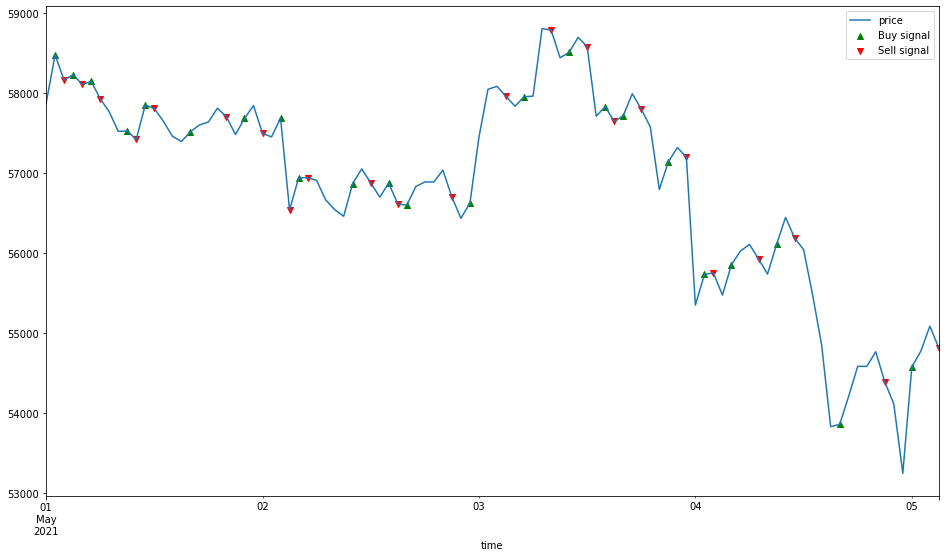

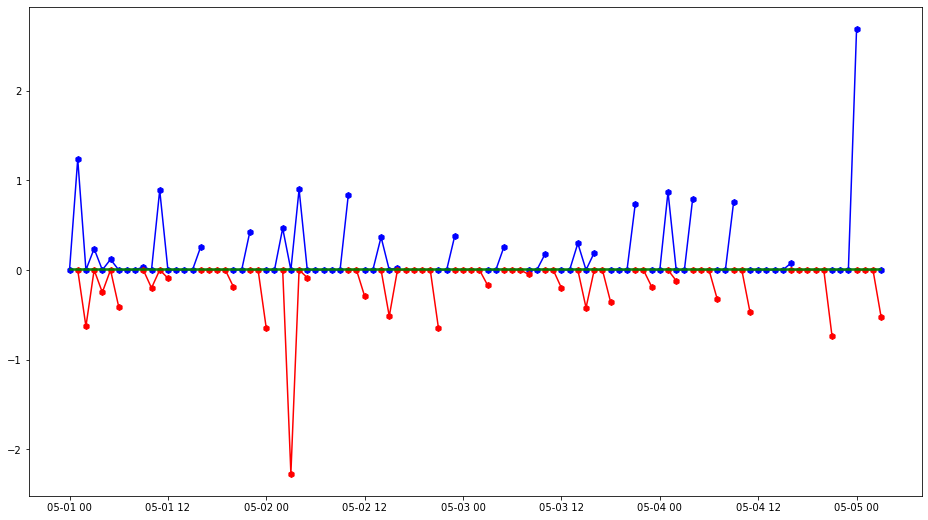

In [15]:
coin = "BTC"

df = (traindf
      .pipe(applyARIMA, coin)
      .pipe(calculateResidualFeature)
      .pipe(createTradeSignal, feature='residualFeature')
     )

plotBeforeAndAfterARIMA(df.head(100))
plotPriceWithSignal(df.head(100))
plotCUSUM(df.head(100))

## 5.  Backtest

Metrics:

- Start
- End
- Duration
- Average exposure time
- Average waiting time

- Equity initial: \$1,000,000
- Equity final
- Cumulative Return: 53.01%
- Sharpe: 1.16
- Sortino: 2.87
- Max Drawdown: -17.49%


In [63]:
# Time
startTime = df.index[0]
endTime = df.index[-1]
duration = endTime - startTime

buyTime = df.loc[df['signal']==1, :].index
sellTime = df.loc[df['signal']==-1, :].index
numberOfCycles = len(sellTime)
buyTimeEven = buyTime[:numberOfCycles]

exposureTime = np.sum(sellTime-buyTimeEven) / numberOfCycles
waitingTime = ((buyTimeEven[0]-df.index[0]) 
               + np.sum(buyTimeEven[1:]-sellTime[:-1])) / numberOfCycles


# Risk

In [60]:
np.sum(buyTimeEven[1:]-sellTime[:-1]) + (buyTimeEven[0]-df.index[0])

Timedelta('57 days 14:00:00')

In [61]:
(buyTimeEven[0]-df.index[0]) + np.sum(buyTimeEven[1:]-sellTime[:-1])

Timedelta('57 days 14:00:00')

In [62]:
waitingTime

Timedelta('0 days 02:30:45.818181818')

In [83]:
df.to_csv("../output/test.csv")

## 6. GridSearchCV for k, h

In [84]:
df.tail()

,price,logPrice,return,signal,equity,share,cPlus,cMinus
time,,,,,,,,
2021-08-31 19:00:00,47313.72,10.764556,-0.000159,0.0,1.233886e+06,26.078814,NaN,0.000000
2021-08-31 20:00:00,46996.26,10.757823,-0.006732,0.0,1.225607e+06,26.078814,NaN,-0.001732
2021-08-31 21:00:00,46949.25,10.756823,-0.001001,0.0,1.224381e+06,26.078814,NaN,0.000000
2021-08-31 22:00:00,47100.37,10.760036,0.003214,0.0,1.228322e+06,26.078814,NaN,0.000000
2021-08-31 23:00:00,47159.26,10.761286,0.001250,0.0,1.229858e+06,26.078814,NaN,0.000000


## 7. Risk Adjusted for BioTech Stocks